In [2]:
# Add modules to the path
import sys
sys.path.insert(0, 'C:\\Users\\francescag\\Documents\\SourceTree_repos\\Python_git')
sys.path.insert(0, 'C:\\Users\\francescag\\Documents\\SourceTree_repos')

import nptdms
import copy
import matplotlib.pyplot as plt
import numpy as np
import scipy.signal
import os
import bpod_open_ephys_analysis.utils.load_nested_structs as load_ns
from OpenEphys_AnalysisHMV.utils.custom_functions import getFirstPulses
import peakutils
from itertools import chain

In [83]:
mouse = 'SNL_photo4'
date = '20190718'

In [82]:
data = nptdms.TdmsFile("W://photometry_2AC//freely_moving_photometry_data//SNL_photo4/20190718_13_53_57/////\\AI.tdms")

In [84]:
chan_0 = data.group_channels('acq_task')[0].data
led405 = data.group_channels('acq_task')[1].data
led465 = data.group_channels('acq_task')[2].data
clock = data.group_channels('acq_task')[3].data
stim_trigger = data.group_channels('acq_task')[4].data

In [59]:
def am_demodulate(signal, reference, modulation_frequency, sample_rate=10000, low_cut=15, order=5):
    normalised_reference = reference - reference.mean()
    samples_per_period = sample_rate / modulation_frequency
    samples_per_quarter_period = round(samples_per_period / 4)

    shift_90_degrees = np.roll(normalised_reference, samples_per_quarter_period)

    in_phase = signal * normalised_reference
    in_phase_filtered = _apply_butterworth_lowpass_filter(in_phase, low_cut_off=low_cut, fs=sample_rate, order=order)

    quadrature = signal * shift_90_degrees
    quadrature_filtered = _apply_butterworth_lowpass_filter(quadrature, low_cut_off=low_cut, fs=sample_rate, order=order)

    return quadrature_filtered, in_phase_filtered


def _demodulate_quadrature(quadrature, in_phase):
    return (quadrature ** 2 + in_phase ** 2) ** 0.5


def _apply_butterworth_lowpass_filter(demod_signal, low_cut_off=15, fs=10000, order=5):
    w = low_cut_off / (fs / 2)  # Normalize the frequency
    b, a = scipy.signal.butter(order, w, 'low')
    output = scipy.signal.filtfilt(b, a, demod_signal)
    return output


def demodulate(raw, ref_211, ref_531):

    q211, i211 = am_demodulate(raw, ref_211, 211, sample_rate=10000)
    q531, i531 = am_demodulate(raw, ref_531, 531, sample_rate=10000)
    demodulated_211 = _demodulate_quadrature(q211, i211)
    demodulated_531 = _demodulate_quadrature(q531, i531)

    return demodulated_211, demodulated_531


def lerner_deisseroth_preprocess(photodetector_raw_data, reference_channel_211hz, reference_channel_531hz):
    """process data according to https://www.ncbi.nlm.nih.gov/pubmed/26232229 , supplement 11"""
    demodulated_211, demodulated_531 = demodulate(photodetector_raw_data,
                                                  reference_channel_211hz,
                                                  reference_channel_531hz)

    signal = _apply_butterworth_lowpass_filter(demodulated_211, 2, order=2)
    background = _apply_butterworth_lowpass_filter(demodulated_531, 2, order=2)

    regression_params = np.polyfit(background, signal, 1)
    bg_fit = regression_params[0] * background + regression_params[1]

    delta_f = (signal-bg_fit)/bg_fit
    return delta_f

In [85]:
demod_signal = lerner_deisseroth_preprocess(chan_0, led465, led405)

In [86]:
peaks = peakutils.indexes(demod_signal)
big_peaks = [peak for peak in peaks if demod_signal[peak]>0.015]

(-0.02, 0.2)

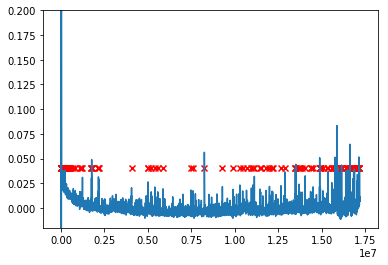

In [38]:
plt.plot(demod_signal)
plt.scatter(big_peaks,np.ones((len(big_peaks)))*0.04, marker='x', color='r')
plt.ylim([-0.02, 0.2])


(-0.01, 0.08)

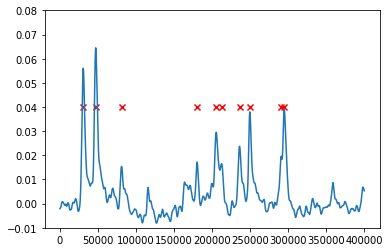

In [39]:
percent_signal = demod_signal[-600000:-200000]
local_peaks = peakutils.indexes(percent_signal, thres=0)
local_big_peaks = [peak for peak in local_peaks if percent_signal[peak]>0.015]
plt.plot( percent_signal)
plt.scatter(local_big_peaks, np.ones((len(local_big_peaks)))*0.04, marker='x', color='r')
plt.ylim([-0.01, 0.08])

In [87]:
len(big_peaks)

1071

In [88]:
Bpod_data_path = 'W:\\photometry_2AC\\bpod_data\\' + mouse + '\\Two_Alternative_Choice\\Session Data\\'
Bpod_file_search_tool = mouse + '_Two_Alternative_Choice_' + date
files_in_bpod_path = os.listdir(Bpod_data_path)
files_on_that_day = [s for s in files_in_bpod_path if Bpod_file_search_tool in s]
mat_files_on_that_day = [s for s in files_on_that_day if '.mat' in s]

if len(mat_files_on_that_day) == 2:
    no_extension_files = [os.path.splitext(filename)[0] for filename in mat_files_on_that_day]
    file_times = [filename.split('_')[-1] for filename in no_extension_files]
    main_session_file = mat_files_on_that_day[file_times.index(max(file_times))]
elif len(mat_files_on_that_day) == 1:
    no_extension_files = [os.path.splitext(filename)[0] for filename in mat_files_on_that_day]
    file_times = [filename.split('_')[-1] for filename in no_extension_files]
    main_session_file = mat_files_on_that_day[file_times.index(max(file_times))]
else: print('more than 2 sessions that day!')

In [89]:
main_session_file

'SNL_photo4_Two_Alternative_Choice_20190718_135415.mat'

In [90]:
# gets the Bpod data out of MATLAB struct and into python-friendly format
loaded_bpod_file = load_ns.loadmat(Bpod_data_path + main_session_file)

# as RawEvents.Trial is a cell array of structs in MATLAB, we have to loop through the array and convert the structs to dicts
trial_raw_events = loaded_bpod_file['SessionData']['RawEvents']['Trial']

for trial_num, trial in enumerate(trial_raw_events):
    trial_raw_events[trial_num] = load_ns._todict(trial)
    
loaded_bpod_file['SessionData']['RawEvents']['Trial'] = trial_raw_events
trial_settings = loaded_bpod_file['SessionData']['TrialSettings']    
first_trial = trial_raw_events[0]
first_trial_TTL = first_trial['States']['TrialStart']

In [91]:
stim_trigger_gaps = np.diff(stim_trigger)
trial_start_ttls_daq = np.where(stim_trigger_gaps > 2.5)
trial_start_ttls_daq = trial_start_ttls_daq[0]/10000
trial_start_ttls_daq.shape

(860,)

In [92]:
loaded_bpod_file['SessionData']['RawData']['OriginalStateNamesByNumber'][0]

array(['TrialStart', 'WaitForPoke', 'CueDelay', 'WaitForPortOut',
       'WaitForResponse', 'LeftReward', 'RightReward', 'Drinking',
       'Punish', 'EarlyWithdrawal'], dtype=object)

In [93]:
original_states = loaded_bpod_file['SessionData']['RawData']['OriginalStateData']
len(original_states)

860

In [94]:
original_time_stamps = loaded_bpod_file['SessionData']['RawData']['OriginalStateTimestamps']
len(original_time_stamps)

860

In [95]:
len(trial_start_ttls_daq)

860

In [96]:
def what_is_mouse_doing(original_state_data_all_trials, original_state_timestamps_all_trials, daq_trials_start_ttls):
    all_states = []
    all_time_stamps = []
    for trial, state_timestamps in enumerate(original_state_timestamps_all_trials):
        trial_states = original_state_data_all_trials[trial]
        all_states.append(trial_states)
        all_time_stamps.append(state_timestamps[0:-1] + daq_trials_start_ttls[trial])
        if trial == len(original_state_timestamps_all_trials)-1:
            last_time_stamp = state_timestamps[-1] + daq_trials_start_ttls[trial]
    flat_time_stamps = np.asarray(list(chain.from_iterable(all_time_stamps)))*10000
    flat_states = list(chain.from_iterable(all_states))
    print(last_time_stamp*10000)
    state_durations = np.diff(np.append(flat_time_stamps, last_time_stamp*10000))
    return(flat_states, flat_time_stamps, state_durations)    

In [97]:
continuous_states, continuous_time_stamps, state_durations = what_is_mouse_doing(original_states, original_time_stamps, trial_start_ttls_daq)

52910738.0


In [98]:
 loaded_bpod_file['SessionData']['RawData']['OriginalStateNamesByNumber'][0][5]

'LeftReward'

In [99]:
mean_state_duration = []
state_timestamps = []
num_state_types = loaded_bpod_file['SessionData']['RawData']['OriginalStateNamesByNumber'][0].shape[0]
for state_num in range(0, num_state_types):
    state_inds = np.where(np.asarray(continuous_states) == state_num + 1)
    state_timestamps.append(continuous_time_stamps[state_inds])
    state_type_durations = state_durations[state_inds]
    mean_state_duration.append(np.mean(state_type_durations))
print(len(mean_state_duration))
    

10


C:\Users\francescag\AppData\Local\Continuum\miniconda3\lib\site-packages\numpy\core\fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
C:\Users\francescag\AppData\Local\Continuum\miniconda3\lib\site-packages\numpy\core\_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


In [100]:
def what_state_at_peaks(peaks, continuous_states, continuous_time_stamps):
    peak_states = np.zeros((len(peaks)))
    for peak_num, peak in enumerate(peaks):
        if peak >= continuous_time_stamps[0]:
            stamp_peak_diffs = continuous_time_stamps - peak
            nearest_stamp_ind = np.where(stamp_peak_diffs < 0, stamp_peak_diffs, -np.inf).argmax()
            #nearest_stamp_ind = np.argmin(np.abs(continuous_time_stamps - peak))
            peak_states[peak_num] = continuous_states[nearest_stamp_ind]
        else:
            peak_states[peak_num] = 0
    return(peak_states)

In [101]:
np.asarray(mean_state_duration)/10000

array([0.01      , 3.39726856, 0.09130695, 0.10202047, 0.77019605,
       0.0228    , 0.0267    , 0.2091757 , 1.18336078,        nan])

In [102]:
a, b = np.histogram(what_state_at_peaks(big_peaks, continuous_states, continuous_time_stamps), bins=np.arange(0,12))
c = a[1:]/np.asarray(mean_state_duration)/10000
print(c)

[2.00000000e-06 1.93685012e-06 2.40945522e-06 3.03860603e-06
 2.02545833e-06 0.00000000e+00 1.12359551e-06 2.96401537e-06
 9.12654891e-07            nan]


([<matplotlib.axis.XTick at 0x1a58ceb8>,
 <a list of 10 Text xticklabel objects>)

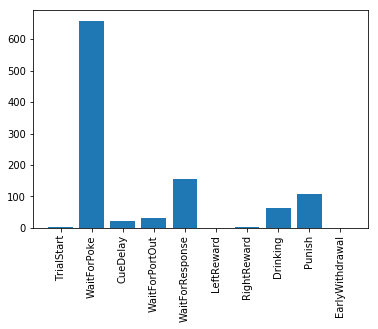

In [103]:
a_short = a[1:]
plt.bar(range(1,11), a_short)
plt.xticks(range(1,11), loaded_bpod_file['SessionData']['RawData']['OriginalStateNamesByNumber'][0], rotation=90)

In [104]:
loaded_bpod_file['SessionData']['RawData']['OriginalStateNamesByNumber'][0][5]

'LeftReward'

([<matplotlib.axis.XTick at 0x4034b160>,
 <a list of 10 Text xticklabel objects>)

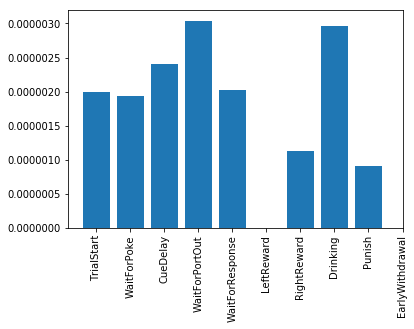

In [105]:
plt.bar(range(1,11), c)
plt.xticks(range(1,11), loaded_bpod_file['SessionData']['RawData']['OriginalStateNamesByNumber'][0], rotation=90)

In [202]:
daq_num_trials = trial_start_ttls_daq.shape[0]
bpod_num_trials = trial_raw_events.shape[0]
if daq_num_trials != bpod_num_trials:
    print('numbers of trials do not match!')
    print('daq: ', daq_num_trials)
    print('bpod: ', bpod_num_trials)

In [203]:
# convert state times to daq timestamps
daq_timed_states = []
daq_timed_events = []
left_reward_times = []
right_reward_times = []
centre_poke_times = []
left_trial_nums = []
mid_light_on_times = trial_start_ttls_daq + 0.01
side_light_on_times = []
centre_port_out_times = []
centre_port_in_times = []
drinking_times = []
for trial_num, trial in enumerate(trial_raw_events):
    trial_states = copy.deepcopy(trial['States'])
    trial_events = copy.deepcopy(trial['Events'])
    daq_timed_states.append(trial_states)
    daq_timed_events.append(trial_events)
    for state in daq_timed_states[trial_num]:
        daq_timed_states[trial_num][state] += trial_start_ttls_daq[trial_num]
    for event in daq_timed_events[trial_num]:
        daq_timed_events[trial_num][event] += trial_start_ttls_daq[trial_num]
    if np.isnan(daq_timed_states[trial_num]['LeftReward'][0]) == 0:
        left_reward_times.append(daq_timed_states[trial_num]['Drinking'][1])
        left_trial_nums.append(trial_num)
    if np.isnan(daq_timed_states[trial_num]['RightReward'][0]) == 0:
        right_reward_times.append(daq_timed_states[trial_num]['Drinking'][1])
    if  np.isnan(daq_timed_states[trial_num]['WaitForResponse'][0]) == 0:
        if type(daq_timed_states[trial_num]['WaitForPoke'][1]) != np.ndarray:
            centre_poke_times.append(daq_timed_states[trial_num]['WaitForPoke'][1])
    side_light_on_times.append(daq_timed_states[trial_num]['WaitForResponse'][0])
    centre_port_out_times.append(daq_timed_states[trial_num]['WaitForPortOut'][1])
    if  np.isnan(daq_timed_states[trial_num]['Drinking'][0]) == 0:
        drinking_times.append(daq_timed_states[trial_num]['WaitForPortOut'][0])
    


In [204]:
loaded_bpod_file['SessionData']['RawData']['OriginalStateNamesByNumber'][0]

array(['TrialStart', 'WaitForPoke', 'CueDelay', 'WaitForPortOut',
       'WaitForResponse', 'LeftReward', 'RightReward', 'Drinking',
       'Punish', 'EarlyWithdrawal'], dtype=object)

In [205]:
left_next_trial_times = []
for idx, trial_num in enumerate(left_trial_nums):
    if trial_num != len(trial_start_ttls_daq)-1:
        left_next_trial_times.append((trial_start_ttls_daq[trial_num + 1] - left_reward_times[idx] + 0.01)*10000)

In [206]:
a = []
for trial_num, trial in enumerate(trial_raw_events):
    if np.isnan(trial['States']['Drinking'][1]) == 0:
        a.append(trial['States']['Drinking'][1])
np.mean(a)

2.269196385542169

In [207]:
def get_photometry_around_event(all_trial_event_times, demodulated_trace, pre_window=5, post_window=5):
    num_events = len(all_trial_event_times)
    event_photo_traces = np.zeros((num_events, 10000*(pre_window + post_window)))
    for event_num, event_time in enumerate(all_trial_event_times):
        plot_start = int(event_time*10000) - pre_window*10000
        plot_end = int(event_time*10000) + post_window*10000
        if plot_end - plot_start != 10000*10:
            print(event_time)
            plot_start = plot_start + 1
            print(plot_end - plot_start)
        event_photo_traces[event_num, :] = demodulated_trace[plot_start:plot_end]
    return(event_photo_traces)

In [257]:
Preward_photo_traces =get_photometry_around_event(state_timestamps[2]/10000, demod_signal)
norm_PR_traces = Preward_photo_traces.T - np.mean(Preward_photo_traces, axis=1)

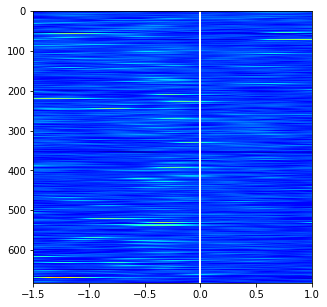

In [259]:
# heatmap raw data
fig_heatmap, ax_heatmap = plt.subplots(figsize=(5, 5))
ax_heatmap.imshow(norm_PR_traces.T,  aspect='auto', extent=[-5,5,len(list(state_timestamps[0])),0], cmap='jet')
ax_heatmap.axvline(0, color='w', linewidth=2)
ax_heatmap.tick_params(labelsize=10)
plt.xlim((-1.5,1))
plt.show()

In [260]:
drinking_traces = get_photometry_around_event(drinking_times, demod_signal)
norm_D_traces = drinking_traces.T - np.mean(drinking_traces, axis=1)
mid_light_photo_traces = get_photometry_around_event(mid_light_on_times, demod_signal)
norm_ML_traces = mid_light_photo_traces.T - np.mean(mid_light_photo_traces, axis=1)
side_light_photo_traces = get_photometry_around_event(side_light_on_times, demod_signal)
norm_SL_traces = side_light_photo_traces.T - np.mean(side_light_photo_traces, axis=1)
Lreward_photo_traces = get_photometry_around_event(left_reward_times, demod_signal)
norm_LR_traces = Lreward_photo_traces.T - np.mean(Lreward_photo_traces, axis=1)
Rreward_photo_traces = get_photometry_around_event(right_reward_times, demod_signal)
norm_RR_traces = Rreward_photo_traces.T - np.mean(Rreward_photo_traces, axis=1)
centre_poke_traces =  get_photometry_around_event(centre_poke_times, demod_signal)
norm_CP_traces = centre_poke_traces.T - np.mean(centre_poke_traces, axis=1)
centre_poke_out_traces = get_photometry_around_event(centre_port_out_times, demod_signal)
norm_CPO_traces = centre_poke_out_traces.T - np.mean(centre_poke_out_traces, axis=1)
centre_poke_in_traces = get_photometry_around_event(centre_port_out_times, demod_signal)
norm_CPI_traces = centre_poke_out_traces.T - np.mean(centre_poke_out_traces, axis=1)

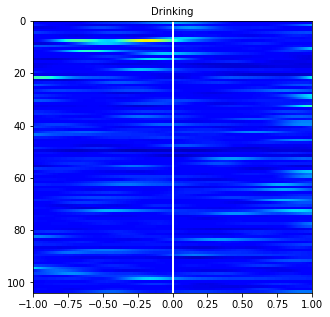

In [134]:
# heatmap raw data
fig_heatmap, ax_heatmap = plt.subplots(figsize=(5, 5 ))
ax_heatmap.imshow(norm_D_traces.T,  aspect='auto', extent=[-5,5,len(drinking_traces),0], cmap='jet')
ax_heatmap.axvline(0, color='w', linewidth=2)
ax_heatmap.tick_params(labelsize=10)
plt.xlim((-1.5,1))
plt.title('Drinking', size=10)
plt.show()

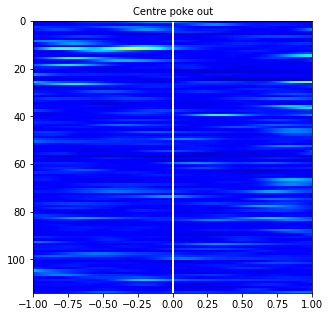

In [135]:
# heatmap raw data
fig_heatmap, ax_heatmap = plt.subplots(figsize=(5, 5 ))
ax_heatmap.imshow(norm_CPO_traces.T,  aspect='auto', extent=[-5,5,len(centre_poke_out_traces),0], cmap='jet')
ax_heatmap.axvline(0, color='w', linewidth=2)
ax_heatmap.tick_params(labelsize=10)
plt.xlim((-1,1))
plt.title('Centre poke out', size=10)
plt.show()

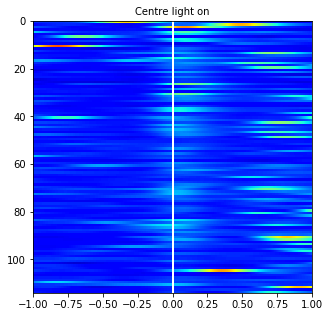

In [136]:
# heatmap raw data
fig_heatmap, ax_heatmap = plt.subplots(figsize=(5, 5))
ax_heatmap.imshow(norm_ML_traces.T,  aspect='auto', extent=[-5,5,len(mid_light_on_times),0], cmap='jet')
ax_heatmap.axvline(0, color='w', linewidth=2)
ax_heatmap.tick_params(labelsize=10)
plt.xlim((-1,1))
plt.title('Centre light on', size=10)
plt.show()

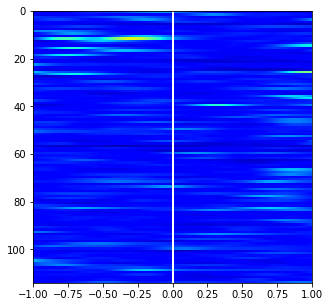

In [137]:
# heatmap raw data
fig_heatmap, ax_heatmap = plt.subplots(figsize=(5, 5))
ax_heatmap.imshow(norm_SL_traces.T,  aspect='auto', extent=[-5,5,len(side_light_on_times),0], cmap='jet')
ax_heatmap.axvline(0, color='w', linewidth=2)
ax_heatmap.tick_params(labelsize=10)
plt.xlim((-1,1))
plt.show()

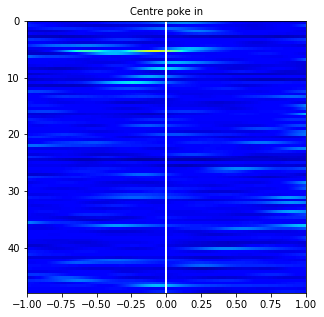

In [138]:
# heatmap raw data
fig_heatmap, ax_heatmap = plt.subplots(figsize=(5, 5))
ax_heatmap.imshow(norm_CP_traces.T,  aspect='auto', extent=[-5,5,len(left_reward_times),0], cmap='jet')
ax_heatmap.axvline(0, color='w', linewidth=2)
ax_heatmap.tick_params(labelsize=10)
plt.xlim((-1,1))
plt.title('Centre poke in', size=10)
plt.show()

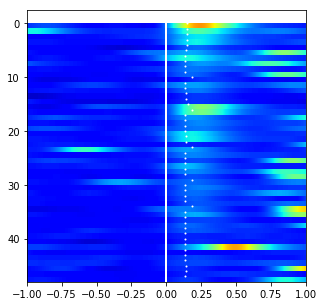

In [159]:
# heatmap raw data
fig_heatmap, ax_heatmap = plt.subplots(figsize=(5, 5))
ax_heatmap.imshow(norm_LR_traces.T,  aspect='auto', extent=[-5,5,len(left_reward_times),0], cmap='jet')
ax_heatmap.axvline(0, color='w', linewidth=2)

ax_heatmap.scatter(np.asarray(left_next_trial_times)/10000, range(0, len(left_next_trial_times)), color='w', s=1)
ax_heatmap.tick_params(labelsize=10)
plt.xlim((-1,1))
plt.show()

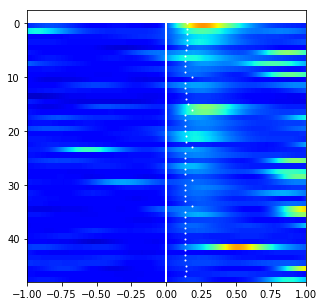

In [160]:
# heatmap raw data
fig_heatmap, ax_heatmap = plt.subplots(figsize=(5, 5))
ax_heatmap.imshow(norm_PR_traces.T,  aspect='auto', extent=[-5,5,len(list(state_timestamps[5])),0], cmap='jet')
ax_heatmap.axvline(0, color='w', linewidth=2)

ax_heatmap.scatter(np.asarray(left_next_trial_times)/10000, range(0, len(left_next_trial_times)), color='w', s=1)
ax_heatmap.tick_params(labelsize=10)
plt.xlim((-1,1))
plt.show()

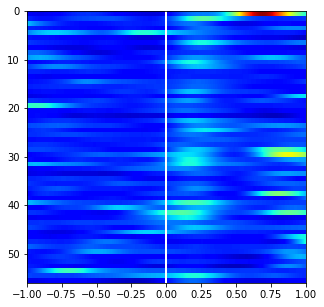

In [140]:
# heatmap raw data
fig_heatmap, ax_heatmap = plt.subplots(figsize=(5, 5))
ax_heatmap.imshow(norm_RR_traces.T,  aspect='auto', extent=[-5,5,len(right_reward_times),0], cmap='jet')
ax_heatmap.axvline(0, color='w', linewidth=2)
plt.xlim((-1,1))
plt.show()

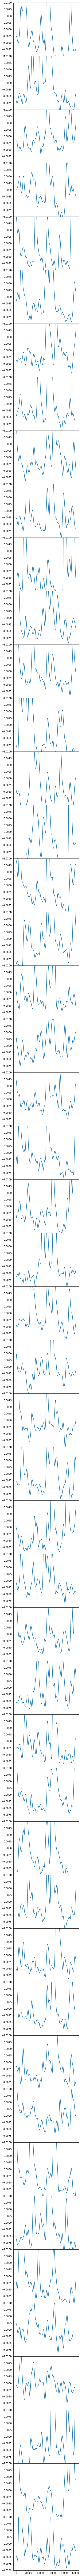

In [141]:
fig, axs = plt.subplots(len(left_reward_times), 1 , figsize = (5,200), facecolor='w', edgecolor='k', sharex=True)
fig.subplots_adjust(hspace = .001, wspace=.001)
axs = axs.ravel()
for reward_num, reward_time in enumerate(left_reward_times):
    axs[reward_num].plot(norm_LR_traces[:,reward_num])
    axs[reward_num].set_ylim((-0.01,0.01))

In [142]:
norm_ML_traces.shape

(100000, 114)

In [97]:
plt.scatter(range(1,11), c)